References:

Blogpost - https://medium.com/codex/tensorflow-deep-learning-recommenders-on-retail-dataset-ce0c50aff5fa

Source Dataset Citation - 
Olist, and André Sionek. (2018). Brazilian E-Commerce Public Dataset by Olist [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/195341

In [1]:
##### WARNING #####
# Ignore below warning for now as it keeps coming even after installing tensorrt manually
# W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
##### ####### #####

# Import libraries
import os
import pandas as pd
import numpy as np
from typing import Dict, Text
import matplotlib.pyplot as plt

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import tensorflow as tf
import tensorflow_recommenders as tfrs

2024-04-21 18:33:02.462902: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**Data Pre-processing**

In [2]:
masterdf = pd.read_csv(
    '../data/clean_olist_data.csv'
)

masterdf.head(3)

,order_id,timestamp,user_id,customer_city,product_category,product_id,quantity,price,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,1506941793,7c396fd4830fd04220f754e42b4e5bff,sao paulo,housewares,housewares SKU 0,1.0,29.99,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,1532464897,af07308b275d755c9edb36a90c618231,barreiras,perfumery,perfumery SKU 0,1.0,118.70,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,1533717529,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,auto,auto SKU 0,1.0,159.90,5.0


In [3]:
masterdf[['user_id',
          'product_id',
          ]] = masterdf[['user_id','product_id']].astype(str)

In [4]:
masterdf['quantity'] = masterdf['quantity'].astype(float)

In [5]:
masterdf.head()

,order_id,timestamp,user_id,customer_city,product_category,product_id,quantity,price,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,1506941793,7c396fd4830fd04220f754e42b4e5bff,sao paulo,housewares,housewares SKU 0,1.0,29.99,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,1532464897,af07308b275d755c9edb36a90c618231,barreiras,perfumery,perfumery SKU 0,1.0,118.70,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,1533717529,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,auto,auto SKU 0,1.0,159.90,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,1511033286,7c142cf63193a1473d2e66489a9ae977,sao goncalo do amarante,pet_shop,pet_shop SKU 0,1.0,45.00,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,1518556719,72632f0f9dd73dfee390c9b22eb56dd6,santo andre,stationery,stationery SKU 0,1.0,19.90,5.0


In [6]:
interactions_dict = masterdf.groupby(['user_id', 'product_id'])[ 'quantity'].sum().reset_index()
interactions_dict.head()

,user_id,product_id,quantity
0,0000366f3b9a7992bf8c76cfdf3221e2,bed_bath_table SKU 513,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,health_beauty SKU 497,1.0
2,0000f46a3911fa3c0805444483337064,stationery SKU 374,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,telephony SKU 1014,1.0
4,0004aac84e0df4da2b147fca70cf8255,telephony SKU 701,1.0


In [7]:
interactions_dict = {name: np.array(value) for name, value in interactions_dict.items()}
interactions_dict

{'user_id': array(['0000366f3b9a7992bf8c76cfdf3221e2',
        '0000b849f77a49e4a4ce2b2a4ca5be3f',
        '0000f46a3911fa3c0805444483337064', ...,
        'ffff371b4d645b6ecea244b27531430a',
        'ffff5962728ec6157033ef9805bacc48',
        'ffffd2657e2aad2907e67c3e9daecbeb'], dtype=object),
 'product_id': array(['bed_bath_table SKU 513', 'health_beauty SKU 497',
        'stationery SKU 374', ..., 'auto SKU 1086', 'watches_gifts SKU 7',
        'perfumery SKU 24'], dtype=object),
 'quantity': array([1., 1., 1., ..., 1., 1., 1.])}

In [8]:
interactions = tf.data.Dataset.from_tensor_slices(interactions_dict)
interactions

2024-04-21 18:33:12.663342: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


<_TensorSliceDataset element_spec={'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'product_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'quantity': TensorSpec(shape=(), dtype=tf.float64, name=None)}>

In [9]:
items_dict = masterdf[['product_id']].drop_duplicates()
items_dict.head()

,product_id
0,housewares SKU 0
1,perfumery SKU 0
2,auto SKU 0
3,pet_shop SKU 0
4,stationery SKU 0


In [10]:
items_dict = {name: np.array(value) for name, value in items_dict.items()}
items_dict

{'product_id': array(['housewares SKU 0', 'perfumery SKU 0', 'auto SKU 0', ...,
        'musical_instruments SKU 288', 'health_beauty SKU 2442',
        'health_beauty SKU 2443'], dtype=object)}

In [11]:
items = tf.data.Dataset.from_tensor_slices(items_dict)
items

<_TensorSliceDataset element_spec={'product_id': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [12]:
interactions = interactions.map(lambda x: {
    'user_id' : x['user_id'],
    'product_id' : x['product_id'],
    'quantity' : float(x['quantity']),

})
interactions

<_MapDataset element_spec={'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'product_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'quantity': TensorSpec(shape=(), dtype=tf.float32, name=None)}>

In [13]:
items = items.map(lambda x: x['product_id'])
items

<_MapDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [14]:
unique_item_titles = np.unique(np.concatenate(list(items.batch(1000))))
unique_item_titles

2024-04-21 18:33:25.178645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


array([b'UNKNOWN SKU 0', b'UNKNOWN SKU 1', b'UNKNOWN SKU 10', ...,
       b'watches_gifts SKU 997', b'watches_gifts SKU 998',
       b'watches_gifts SKU 999'], dtype=object)

In [15]:
unique_user_ids = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["user_id"]))))
unique_user_ids

2024-04-21 18:33:29.711631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


array([b'0000366f3b9a7992bf8c76cfdf3221e2',
       b'0000b849f77a49e4a4ce2b2a4ca5be3f',
       b'0000f46a3911fa3c0805444483337064', ...,
       b'ffff371b4d645b6ecea244b27531430a',
       b'ffff5962728ec6157033ef9805bacc48',
       b'ffffd2657e2aad2907e67c3e9daecbeb'], dtype=object)

In [16]:
tf.random.set_seed(42)
shuffled = interactions.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(60_000)
test = shuffled.skip(60_000).take(20_000)

**Retrieval model**

Retrieval task selects an initial set of candidate among all possible choices. The objective is to eliminate candidate that a user may not be interested. Retrieval task can deal with millions of candidate and only returns a handful of items, therefore it can save computational power and memory.

In [17]:
class RetailModel(tfrs.Model):

    def __init__(self, user_model, item_model):
        super().__init__()

        ### Candidate model (item)
        ### This is Keras preprocessing layers to first convert user ids to integers,
        ### and then convert those to user embeddings via an Embedding layer.
        ### We use the list of unique user ids we computed earlier as a vocabulary:
        item_model = tf.keras.Sequential([
                                        tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_item_titles, mask_token=None),
                                        tf.keras.layers.Embedding(len(unique_item_titles) + 1, embedding_dimension)
                                        ])
        ### we pass the embedding layer into item model
        self.item_model: tf.keras.Model = item_model

        ### Query model (users)
        user_model = tf.keras.Sequential([
                                        tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_user_ids, mask_token=None),
                                        # We add an additional embedding to account for unknown tokens.
                                        tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
                                        ])
        self.user_model: tf.keras.Model = user_model

        ### for retrieval model. we take top-k accuracy as metrics
        metrics = tfrs.metrics.FactorizedTopK(
                                            candidates=items.batch(128).map(item_model)
        )

        # define the task, which is retrieval                                    )
        task = tfrs.tasks.Retrieval(
                                    metrics=metrics
                                    )

        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["user_id"])
        # And pick out the movie features and pass them into the movie model,
        # getting embeddings back.
        positive_movie_embeddings = self.item_model(features["product_id"])

        # The task computes the loss and the metrics.
        return self.task(user_embeddings, positive_movie_embeddings)

In [19]:
### Fitting and evaluating

### we choose the dimensionality of the query and candicate representation.
embedding_dimension = 32

## we pass the model, which is the same model we created in the query and candidate tower, into the model
item_model = tf.keras.Sequential([
                                tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_item_titles, mask_token=None),
                                tf.keras.layers.Embedding(len(unique_item_titles) + 1, embedding_dimension)
                                ])

user_model = tf.keras.Sequential([
                                tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_user_ids, mask_token=None),
                                # We add an additional embedding to account for unknown tokens.
                                tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
                                ])

model = RetailModel(user_model, item_model)

# a smaller learning rate may make the model move slower and prone to overfitting, so we stick to 0.1
# other optimizers, such as SGD and Adam, are listed here https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

## fit the model with ten epochs
model_hist = model.fit(cached_train, epochs=10)

#evaluate the model
model.evaluate(cached_test, return_dict=True)

Epoch 1/10
8/8 [==============================] - 288s 34s/step - factorized_top_k/top_1_categorical_accuracy: 9.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0037 - factorized_top_k/top_10_categorical_accuracy: 0.0050 - factorized_top_k/top_50_categorical_accuracy: 0.0101 - factorized_top_k/top_100_categorical_accuracy: 0.0139 - loss: 62067.2344 - regularization_loss: 0.0000e+00 - total_loss: 62067.2344
Epoch 2/10
8/8 [==============================] - 271s 33s/step - factorized_top_k/top_1_categorical_accuracy: 0.0443 - factorized_top_k/top_5_categorical_accuracy: 0.1319 - factorized_top_k/top_10_categorical_accuracy: 0.1843 - factorized_top_k/top_50_categorical_accuracy: 0.3852 - factorized_top_k/top_100_categorical_accuracy: 0.5137 - loss: 61842.9540 - regularization_loss: 0.0000e+00 - total_loss: 61842.9540
Epoch 3/10
8/8 [==============================] - 265s 33s/step - factorized_top_k/top_1_categorical_accuracy: 0.1061 - factorized_top_k/top_5_categorical_accuracy:

{'factorized_top_k/top_1_categorical_accuracy': 0.00019999999494757503,
 'factorized_top_k/top_5_categorical_accuracy': 0.0032500000670552254,
 'factorized_top_k/top_10_categorical_accuracy': 0.005100000184029341,
 'factorized_top_k/top_50_categorical_accuracy': 0.015300000086426735,
 'factorized_top_k/top_100_categorical_accuracy': 0.024900000542402267,
 'loss': 29916.30078125,
 'regularization_loss': 0,
 'total_loss': 29916.30078125}

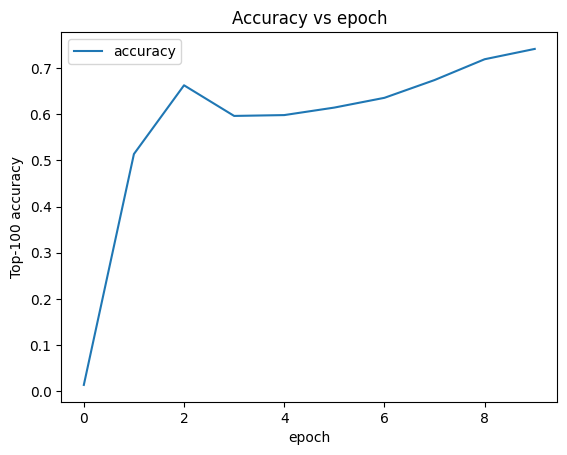

In [ ]:
# num_validation_runs = len(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [i for i in range(10)]

plt.plot(epochs, model_hist.history["factorized_top_k/top_100_categorical_accuracy"], label="accuracy")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

In [ ]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# index

In [ ]:
# recommends movies out of the entire movies dataset.
index.index_from_dataset(items.batch(100).map(lambda title: (title, model.item_model(title))))

2024-04-21 19:14:46.899974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Get recommendations.
_, titles = index(np.array(["42"]))
print(f"Recommendations for user %s: {titles[0, :3]}" %(20))

Recommendations for user 20: [b'health_beauty SKU 493' b'pet_shop SKU 111' b'drinks SKU 7']


**Ranking model**

Ranking, on the other hand, takes the output of retrieval task and select a few best possible items, ranking them from top to bottom. It normally returns a probability score for each item, and sort them from highest score to lowest.

Other approaches that may be implemented:

- Adding text and timestamp embedding

- Multitask recommendation, combining retrieval and ranking

- Add more features using Cross Network